# Transformer Model Training - 12 Lead Features

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from edm.utils.measures import perf_measure, calculate_output_statistics, calculate_confidence_intervals
from pathlib import Path
from edm.jobs.mlp_job import MlpJob

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
# This accompanies the waveforms, to describe each one
processed = pd.read_csv("/deep/group/ed-monitor/admission-ecgs/v1/processed.csv")
print(processed.shape)
processed.head(3)

# Filter for NaN CSNs
print(f"Before {processed.shape}")
print(f"No CSN for: {processed[processed['csn'].isna()]['input_file_name']}")
processed = processed[~processed["csn"].isna()]
print(f"After NaN filtering: {processed.shape}")

csns_processed = set()
indices_to_keep = set()
processed = processed.sort_values(by=['date', 'time'])
for i, row in processed.iterrows():
    try:
        csn = int(row["csn"])

        # TODO: Each CSN could have multiple ECGs taken. Here, we take the first occurrence but we could 
        # expand this to use the average of all ECGs.
        if csn not in csns_processed:
            csns_processed.add(csn)
            indices_to_keep.add(i)
    except:
        pass

print(f"Found {len(csns_processed)} and {len(indices_to_keep)}")

processed = processed[processed.index.isin(indices_to_keep)]
print(processed.shape)
processed["csn"] = processed["csn"].astype(int)

In [ ]:
df_train = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt", sep="\t")
print(df_train.shape)
df_train.head(1)

In [ ]:
df_val = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt", sep="\t")
print(df_val.shape)
df_val.head(1)

In [ ]:
df_test = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt", sep="\t")
print(df_test.shape)
df_test.head(1)

In [7]:
def train(df_train, df_val, df_test, processed, embeddings_path=None, consolidated_cols=[], processed_cols=[], 
          impute=True, normalize=True):
    
    csn_to_index = {}
    if embeddings_path is not None:
        # /deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64
        df_embeddings_summary_12 = pd.read_csv(f"{embeddings_path}/embeddings_summary.csv")
        print(df_embeddings_summary_12.shape)
        embeddings_12 = np.load(f"{embeddings_path}/embeddings.dat.npy")
        print(embeddings_12.shape)
        
        for i, row in df_embeddings_summary_12.iterrows():
            csn_to_index[int(row["record_name"])] = i
    
    left_cols = ["CSN", "outcome"]
    for c in consolidated_cols:
        left_cols.append(c)
    right_cols = ["csn"]
    for c in processed_cols:
        right_cols.append(c)

    df_train = df_train[left_cols]
    df_val = df_val[left_cols]
    df_test = df_test[left_cols]
    
    processed = processed.replace('Invalid', None)
    processed = processed.replace('Failed', None)
    
    processed = processed[right_cols]
    
    
    df_train = pd.merge(df_train, processed, left_on="CSN", right_on="csn")
    df_val = pd.merge(df_val, processed, left_on="CSN", right_on="csn")
    df_test = pd.merge(df_test, processed, left_on="CSN", right_on="csn")

    df_train_csns = df_train["CSN"]
    df_val_csns = df_val["CSN"]
    df_test_csns = df_test["CSN"]

    df_train_y = df_train["outcome"]
    df_val_y = df_val["outcome"]
    df_test_y = df_test["outcome"]

    df_train = df_train.drop(["CSN", "csn", "outcome"], axis=1)
    df_val = df_val.drop(["CSN", "csn", "outcome"], axis=1)
    df_test = df_test.drop(["CSN", "csn", "outcome"], axis=1)
    
    if embeddings_path is not None:
        train_new_rows = []
        val_new_rows = []
        test_new_rows = []
        for csn in df_train_csns.tolist():
            train_new_rows.append(embeddings_12[csn_to_index[csn]])
        for csn in df_val_csns.tolist():
            val_new_rows.append(embeddings_12[csn_to_index[csn]])
        for csn in df_test_csns.tolist():
            test_new_rows.append(embeddings_12[csn_to_index[csn]])
        
        df_train = pd.concat([df_train, pd.DataFrame(data=train_new_rows)], axis=1)
        df_val = pd.concat([df_val, pd.DataFrame(data=val_new_rows)], axis=1)
        df_test = pd.concat([df_test, pd.DataFrame(data=test_new_rows)], axis=1)
    
    if "Gender" in df_train.columns:
        gender_map = {"F": 0, "M": 1, "U": 2}
        df_train["Gender"] = df_train["Gender"].apply(lambda x: gender_map[x])
        df_val["Gender"] = df_val["Gender"].apply(lambda x: gender_map[x])
        df_test["Gender"] = df_test["Gender"].apply(lambda x: gender_map[x])
    
    if impute:
        imp = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
        df_train = pd.DataFrame(
            imp.fit_transform(df_train), 
            index=df_train.index,
            columns=df_train.columns
        )
        df_val = pd.DataFrame(
            imp.transform(df_val), 
            index=df_val.index,
            columns=df_val.columns
        )
        df_test = pd.DataFrame(
            imp.transform(df_test), 
            index=df_test.index,
            columns=df_test.columns
        )

    if normalize:
        sc = StandardScaler()
        df_train = pd.DataFrame(
            sc.fit_transform(df_train), 
            index=df_train.index,
            columns=df_train.columns
        )
        df_val = pd.DataFrame(
            sc.transform(df_val), 
            index=df_val.index,
            columns=df_val.columns
        )
        df_test = pd.DataFrame(
            sc.transform(df_test), 
            index=df_test.index,
            columns=df_test.columns
        )
    
    print(df_train.head(3))

    print(f"Starting model training...")
    clf = LogisticRegression(random_state=42, class_weight=None, max_iter=10000)
    #clf.fit(df_train, df_train_y)
    clf.fit(pd.concat([df_train, df_val]), pd.concat([df_train_y, df_val_y]))


    print()
    print()
    print(f"=== TRAIN ===")
    y_train_pred = clf.predict_proba(df_train)[:, 1]
    auroc_train = calculate_output_statistics(df_train_y.tolist(), y_train_pred)
    calculate_confidence_intervals(df_train_y.tolist(), y_train_pred, ci_type="delong")

    print()
    print()
    print(f"=== VAL ===")
    y_val_pred = clf.predict_proba(df_val)[:, 1]
    auroc_val = calculate_output_statistics(df_val_y.tolist(), y_val_pred)
    calculate_confidence_intervals(df_val_y.tolist(), y_val_pred, ci_type="delong")

    print()
    print()
    print(f"=== TEST ===")
    y_test_pred = clf.predict_proba(df_test)[:, 1]
    auroc_test = calculate_output_statistics(df_test_y.tolist(), y_test_pred)
    calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="delong")
    calculate_confidence_intervals(df_test_y.tolist(), y_test_pred, ci_type="bootstrap")

In [8]:
def save(save_path, df_train, df_val, df_test, processed, embeddings_path=None, consolidated_cols=[], processed_cols=[], 
          impute=True, normalize=True):
    
    csn_to_index = {}
    if embeddings_path is not None:
        # /deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64
        df_embeddings_summary_12 = pd.read_csv(f"{embeddings_path}/embeddings_summary.csv")
        print(df_embeddings_summary_12.shape)
        embeddings_12 = np.load(f"{embeddings_path}/embeddings.dat.npy")
        print(embeddings_12.shape)
        
        for i, row in df_embeddings_summary_12.iterrows():
            csn_to_index[int(row["record_name"])] = i
    
    left_cols = ["CSN", "outcome"]
    for c in consolidated_cols:
        left_cols.append(c)
    right_cols = ["csn"]
    for c in processed_cols:
        right_cols.append(c)

    df_train = df_train[left_cols]
    df_val = df_val[left_cols]
    df_test = df_test[left_cols]
    
    processed = processed.replace('Invalid', None)
    processed = processed.replace('Failed', None)
    
    processed = processed[right_cols]
    
    
    df_train = pd.merge(df_train, processed, left_on="CSN", right_on="csn")
    df_val = pd.merge(df_val, processed, left_on="CSN", right_on="csn")
    df_test = pd.merge(df_test, processed, left_on="CSN", right_on="csn")

    df_train_csns = df_train["CSN"]
    df_val_csns = df_val["CSN"]
    df_test_csns = df_test["CSN"]

    df_train_y = df_train["outcome"]
    df_val_y = df_val["outcome"]
    df_test_y = df_test["outcome"]

    df_train = df_train.drop(["CSN", "csn", "outcome"], axis=1)
    df_val = df_val.drop(["CSN", "csn", "outcome"], axis=1)
    df_test = df_test.drop(["CSN", "csn", "outcome"], axis=1)
    
    if embeddings_path is not None:
        train_new_rows = []
        val_new_rows = []
        test_new_rows = []
        for csn in df_train_csns.tolist():
            train_new_rows.append(embeddings_12[csn_to_index[csn]])
        for csn in df_val_csns.tolist():
            val_new_rows.append(embeddings_12[csn_to_index[csn]])
        for csn in df_test_csns.tolist():
            test_new_rows.append(embeddings_12[csn_to_index[csn]])
        
        df_train = pd.concat([df_train, pd.DataFrame(data=train_new_rows)], axis=1)
        df_val = pd.concat([df_val, pd.DataFrame(data=val_new_rows)], axis=1)
        df_test = pd.concat([df_test, pd.DataFrame(data=test_new_rows)], axis=1)
    
    if "Gender" in df_train.columns:
        gender_map = {"F": 0, "M": 1, "U": 2}
        df_train["Gender"] = df_train["Gender"].apply(lambda x: gender_map[x])
        df_val["Gender"] = df_val["Gender"].apply(lambda x: gender_map[x])
        df_test["Gender"] = df_test["Gender"].apply(lambda x: gender_map[x])
    
    if impute:
        imp = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
        df_train = pd.DataFrame(
            imp.fit_transform(df_train), 
            index=df_train.index,
            columns=df_train.columns
        )
        df_val = pd.DataFrame(
            imp.transform(df_val), 
            index=df_val.index,
            columns=df_val.columns
        )
        df_test = pd.DataFrame(
            imp.transform(df_test), 
            index=df_test.index,
            columns=df_test.columns
        )

    if normalize:
        sc = StandardScaler()
        df_train = pd.DataFrame(
            sc.fit_transform(df_train), 
            index=df_train.index,
            columns=df_train.columns
        )
        df_val = pd.DataFrame(
            sc.transform(df_val), 
            index=df_val.index,
            columns=df_val.columns
        )
        df_test = pd.DataFrame(
            sc.transform(df_test), 
            index=df_test.index,
            columns=df_test.columns
        )
    
#     print(df_train.head(3))

    Path(save_path).mkdir(parents=True, exist_ok=True)

    df_all = pd.concat([df_train, df_val, df_test])
    embeddings = df_all.to_numpy()
    np.save(f"{save_path}/embeddings.dat.npy", embeddings)
    
    csns = df_train_csns.tolist()
    csns.extend(df_val_csns.tolist())
    csns.extend(df_test_csns.tolist())
    df_records = pd.DataFrame({"record_name": csns})
    df_records.to_csv(f"{save_path}/embeddings_summary.csv", index=False)
    


## LR

### ECG Features Only

   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429454  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659404   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720297   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355860 -0.236728 -0.009418  0.093036 -0.156754   -0.281770      0.597293   
1  1.586831  3.630345  3.199030  2.829381  2.889222    0.126090      2.694667   
2 -0.160353  0.736277  0.437660  0.341794  0.346251    0.067824     -0.285812   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40horizaxis  \
0     -0.555135    -0.079516   -0.113176    0.260027      0.345515   
1      0.825396    -1.412913    4.272147   -0.231760      0.467736   
2     -0.555135    -0.852139   -0.700497   -0.157992     -0.461148   

   t40horizaxis  qrshorizaxis  sthorizaxis  
0      1.748398     -0.142217   

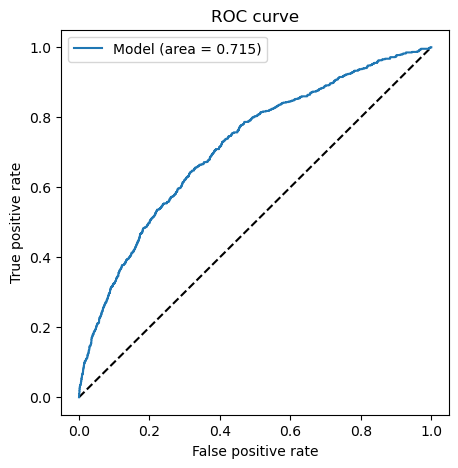

[DeLong] AUC=0.715, AUC COV=0.0, 95% CI=[0.695, 0.736]; AUPRC=0.227, 95% CI=N/A


=== VAL ===


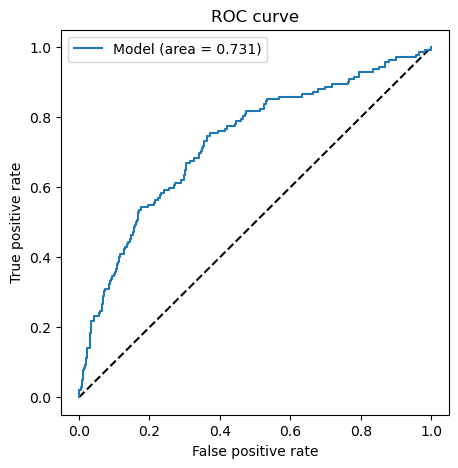

[DeLong] AUC=0.731, AUC COV=0.001, 95% CI=[0.684, 0.777]; AUPRC=0.281, 95% CI=N/A


=== TEST ===


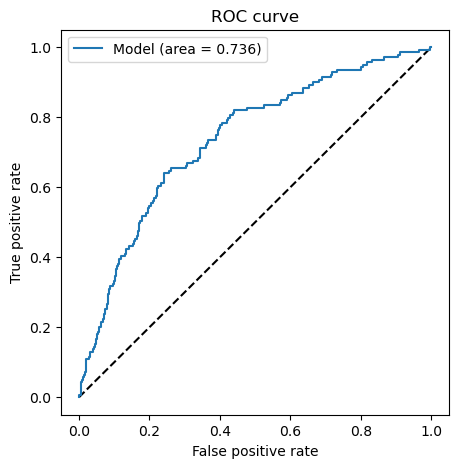

  0%|          | 4/10000 [00:00<05:09, 32.34it/s]

[DeLong] AUC=0.736, AUC COV=0.001, 95% CI=[0.692, 0.78]; AUPRC=0.248, 95% CI=N/A


100%|██████████| 10000/10000 [08:04<00:00, 20.65it/s]

[Bootstrap] AUC=0.736, 95% CI=[0.692, 0.779]; AUPRC=0.248, 95% CI=[0.194, 0.314]


In [9]:
# ECG 
train(df_train, df_val, df_test, processed, consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features Only (David Subset)

In [ ]:
processed.head(1)

In [ ]:
processed_aug = processed
processed_aug['lbbb'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and ("left bundle branch block" in row["statements"].lower() or "lbbb" in row["statements"].lower()) else 0, axis=1)
processed_aug['qwave'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "q wave" in row["statements"].lower() else 0, axis=1)
processed_aug['ste'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "st elevation" in row["statements"].lower() else 0, axis=1)
processed_aug['std'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "st depression" in row["statements"].lower() else 0, axis=1)
processed_aug['avb'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "av block" in row["statements"].lower() else 0, axis=1)
processed_aug['lad'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "left axis deviation" in row["statements"].lower() else 0, axis=1)
processed_aug['vpc'] = processed_aug.apply(lambda row: 1 if isinstance(row["statements"], str) and "ventricular premature complexes" in row["statements"].lower() else 0, axis=1)
processed_aug.head(1)


   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429458  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659409   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720298   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355846 -0.236728 -0.009418  0.093036 -0.156754   -0.281743      0.597331   
1  1.585767  3.630345  3.199030  2.829381  2.889222    0.126128      2.694724   
2 -0.159927  0.736277  0.437660  0.341794  0.346251    0.067860     -0.285783   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40horizaxis  \
0     -0.555135    -0.079519   -0.113185    0.260153      0.344918   
1      0.825396    -1.412922    4.272108   -0.231650      0.467093   
2     -0.555135    -0.852145   -0.700502   -0.157879     -0.461438   

   t40horizaxis  qrshorizaxis  sthorizaxis      lbbb     qwave       ste  \
0

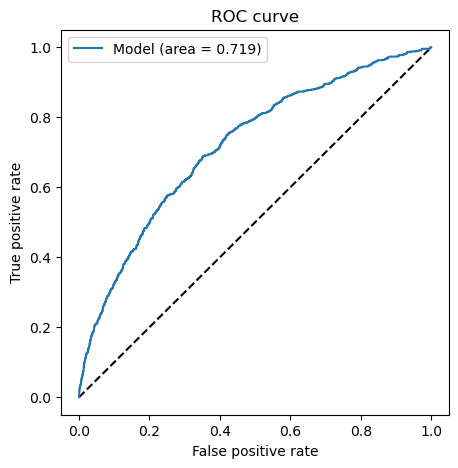

[DeLong] AUC=0.719, AUC COV=0.0, 95% CI=[0.699, 0.74]; AUPRC=0.23, 95% CI=N/A


=== VAL ===


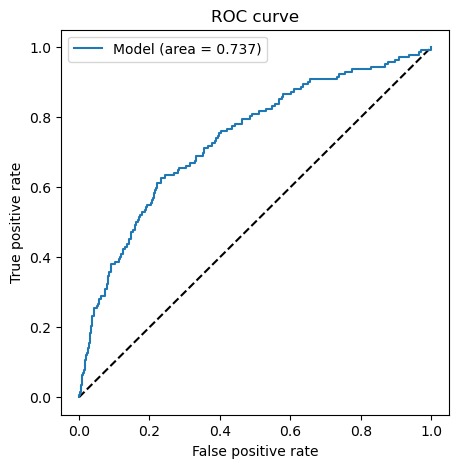

[DeLong] AUC=0.737, AUC COV=0.001, 95% CI=[0.692, 0.783]; AUPRC=0.28, 95% CI=N/A


=== TEST ===


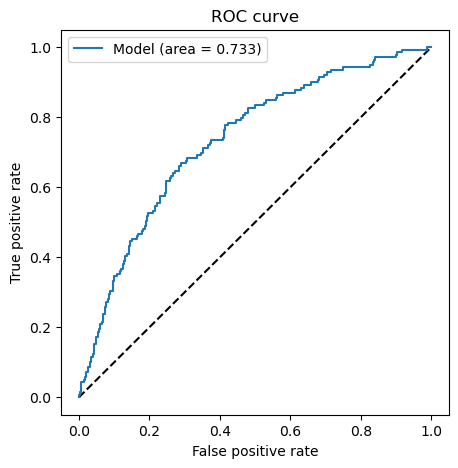

  0%|          | 4/10000 [00:00<05:08, 32.39it/s]

[DeLong] AUC=0.733, AUC COV=0.0, 95% CI=[0.69, 0.776]; AUPRC=0.239, 95% CI=N/A


100%|██████████| 10000/10000 [05:09<00:00, 32.28it/s]

[Bootstrap] AUC=0.733, 95% CI=[0.689, 0.776]; AUPRC=0.239, 95% CI=[0.186, 0.303]


In [28]:
# 'left bundle branch block' or 'LBBB'
# 'q wave'
# 'st elevation'
# 'st depression'
# 'av block'
# 'left axis deviation'
# 'ventricular premature complexes'
train(df_train, df_val, df_test, processed_aug, consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", 
                      "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", 
                      "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", 
                      "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis",
                      "lbbb", "qwave", "ste", "std", "avb", "lad", "vpc"])

### ECG Features + Age + Sex + Vital Signs + Risk

        Age    Gender      SpO2        RR        HR      Temp       SBP  \
0 -0.584271 -0.978968  0.724453 -0.483572 -0.203260  0.092808 -0.250423   
1 -1.058067 -0.978968  0.060205 -0.210238  0.357506 -0.097842 -0.439140   
2 -0.952779  1.020356  0.060205 -1.030242  0.030392  0.283458 -0.173374   

        DBP    Athero       HTN       HLD        DM     Obese   Smoking  \
0 -0.088376 -0.294680 -0.306981 -0.322470 -0.195566  0.174355  0.034779   
1  0.242857 -0.595521  1.792130 -0.750684 -0.706817  4.583490 -0.278366   
2  0.983906 -0.595521 -0.852127 -0.750684 -0.706817 -0.376122 -0.278366   

   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429600  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659583   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720314   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \


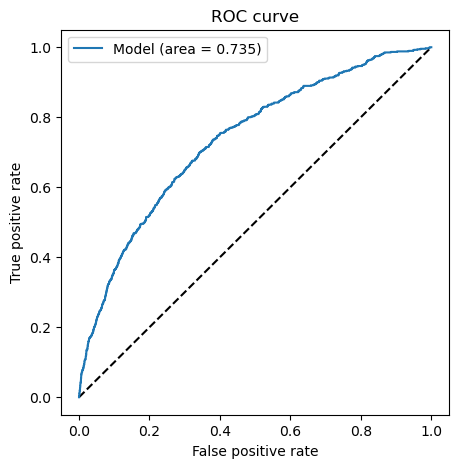

[DeLong] AUC=0.735, AUC COV=0.0, 95% CI=[0.715, 0.755]; AUPRC=0.243, 95% CI=N/A


=== VAL ===


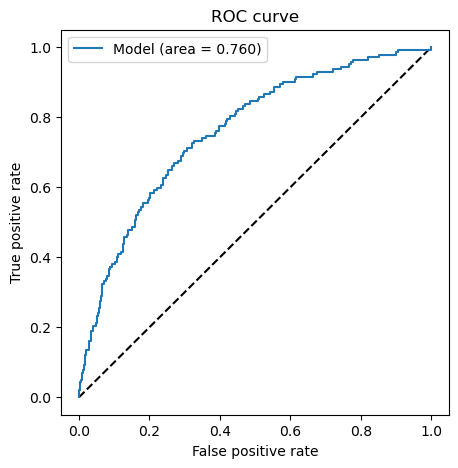

[DeLong] AUC=0.76, AUC COV=0.0, 95% CI=[0.719, 0.801]; AUPRC=0.302, 95% CI=N/A


=== TEST ===


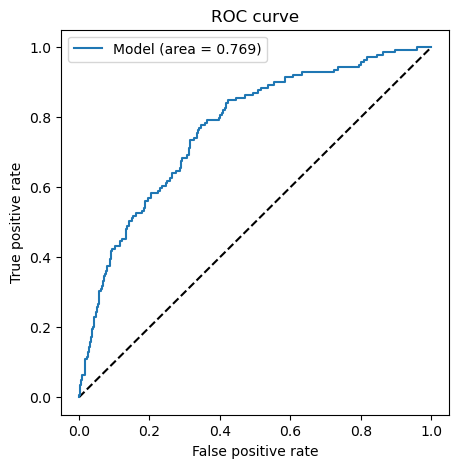

  0%|          | 4/10000 [00:00<05:07, 32.52it/s]

[DeLong] AUC=0.769, AUC COV=0.0, 95% CI=[0.728, 0.81]; AUPRC=0.294, 95% CI=N/A


100%|██████████| 10000/10000 [05:09<00:00, 32.28it/s]

[Bootstrap] AUC=0.769, 95% CI=[0.727, 0.81]; AUPRC=0.294, 95% CI=[0.228, 0.37]


In [35]:
train(df_train, df_val, df_test, processed, normalize=True, consolidated_cols=["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features + Age + Risk

        Age    Athero       HTN       HLD        DM     Obese   Smoking  \
0 -0.584271 -0.176990 -0.211858 -0.244890 -0.139770  0.123483  0.022950   
1 -1.058067 -0.595419  1.799746 -0.751936 -0.708359  4.590936 -0.278676   
2 -0.952779 -0.595419 -0.849675 -0.751936 -0.708359 -0.376679 -0.278676   

   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429622  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659606   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720297   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355878 -0.236728 -0.009418  0.093036 -0.156754   -0.281912      0.597314   
1  1.587292  3.630345  3.199030  2.829381  2.889222    0.126008      2.694707   
2 -0.160522  0.736277  0.437660  0.341794  0.346251    0.067734     -0.285798   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40

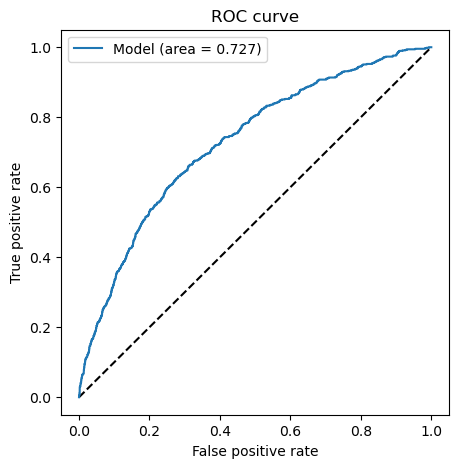

[DeLong] AUC=0.727, AUC COV=0.0, 95% CI=[0.707, 0.747]; AUPRC=0.227, 95% CI=N/A


=== VAL ===


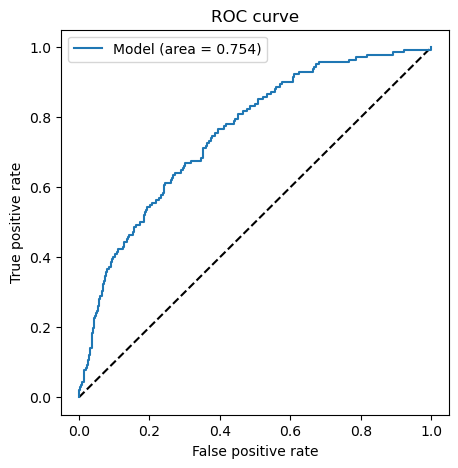

[DeLong] AUC=0.754, AUC COV=0.0, 95% CI=[0.713, 0.795]; AUPRC=0.281, 95% CI=N/A


=== TEST ===


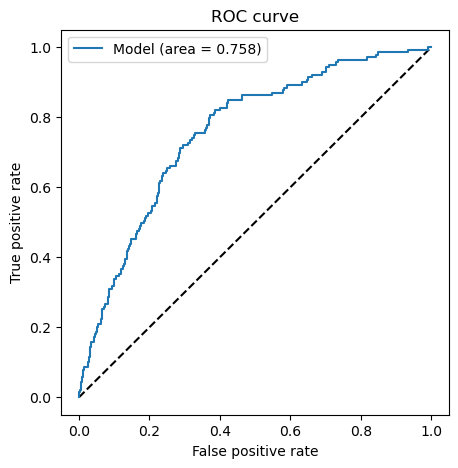

  0%|          | 3/10000 [00:00<06:02, 27.54it/s]

[DeLong] AUC=0.758, AUC COV=0.0, 95% CI=[0.717, 0.798]; AUPRC=0.263, 95% CI=N/A


100%|██████████| 10000/10000 [08:39<00:00, 19.24it/s]

[Bootstrap] AUC=0.758, 95% CI=[0.717, 0.796]; AUPRC=0.263, 95% CI=[0.205, 0.331]


In [10]:
train(df_train, df_val, df_test, processed, normalize=True, consolidated_cols=["Age", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features + 12-Lead Embeddings

(10250, 1)
(10250, 64)
   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429174  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659038   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720148   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355853 -0.236728 -0.009418  0.093036 -0.156754   -0.281069      0.597252   
1  1.587675  3.630345  3.199030  2.829381  2.889222    0.126601      2.694602   
2 -0.160717  0.736277  0.437660  0.341794  0.346251    0.068363     -0.285843   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40horizaxis  \
0     -0.555135    -0.079703   -0.113908    0.165557      0.344404   
1      0.825396    -1.413091    4.260126   -0.289246      0.466427   
2     -0.555135    -0.852321   -0.699716   -0.221026     -0.460948   

   t40horizaxis  qrshorizaxis  sthorizaxis         0  

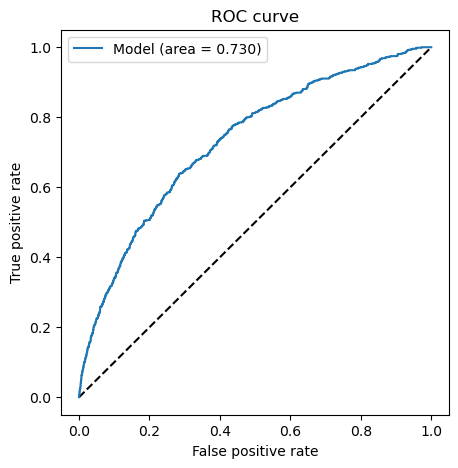

[DeLong] AUC=0.73, AUC COV=0.0, 95% CI=[0.71, 0.75]; AUPRC=0.235, 95% CI=N/A


=== VAL ===


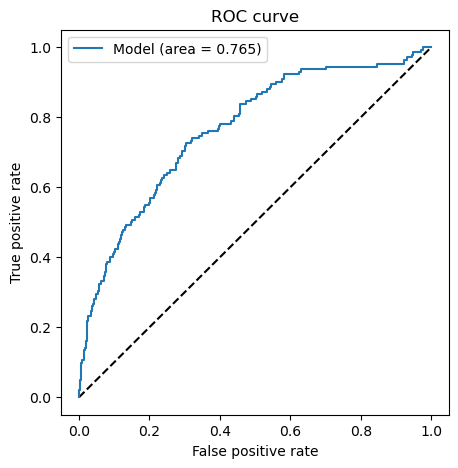

[DeLong] AUC=0.765, AUC COV=0.0, 95% CI=[0.723, 0.808]; AUPRC=0.338, 95% CI=N/A


=== TEST ===


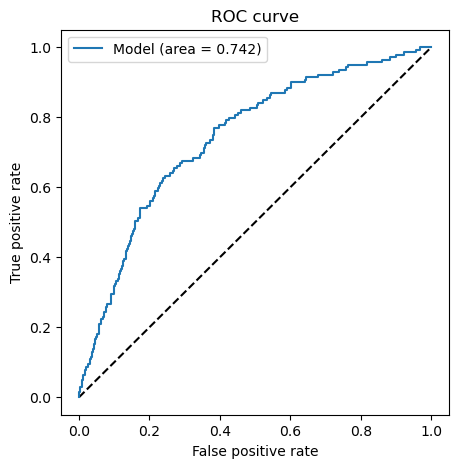

  0%|          | 0/10000 [00:00<?, ?it/s]

[DeLong] AUC=0.742, AUC COV=0.0, 95% CI=[0.699, 0.785]; AUPRC=0.246, 95% CI=N/A


100%|██████████| 10000/10000 [09:56<00:00, 16.75it/s]

[Bootstrap] AUC=0.742, 95% CI=[0.698, 0.784]; AUPRC=0.246, 95% CI=[0.192, 0.315]


In [11]:
# ECG Features + Embeddings

train(df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64", consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features + 12-Lead Embeddings + Monitoring Embeddings

(10250, 1)
(10250, 128)
   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429306  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659181   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720070   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355684 -0.236728 -0.009418  0.093036 -0.156754   -0.273653      0.597221   
1  1.588154  3.630345  3.199030  2.829381  2.889222    0.133218      2.694541   
2 -0.161159  0.736277  0.437660  0.341794  0.346251    0.075094     -0.285862   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40horizaxis  \
0     -0.555135    -0.079870   -0.114526    0.129669      0.344103   
1      0.825396    -1.413278    4.257800   -0.307253      0.466104   
2     -0.555135    -0.852499   -0.700106   -0.241715     -0.461104   

   t40horizaxis  qrshorizaxis  sthorizaxis         0 

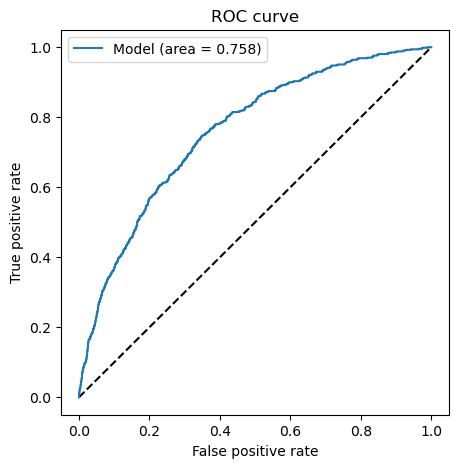

[DeLong] AUC=0.758, AUC COV=0.0, 95% CI=[0.74, 0.777]; AUPRC=0.252, 95% CI=N/A


=== VAL ===


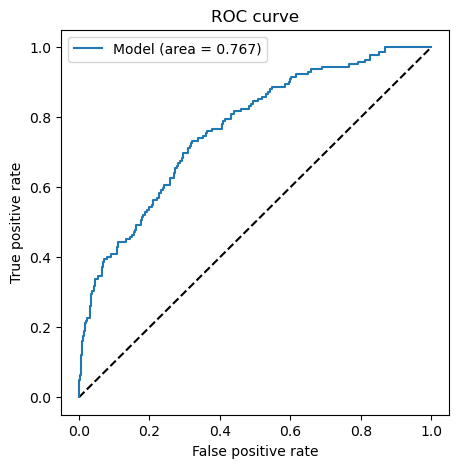

[DeLong] AUC=0.767, AUC COV=0.0, 95% CI=[0.726, 0.808]; AUPRC=0.373, 95% CI=N/A


=== TEST ===


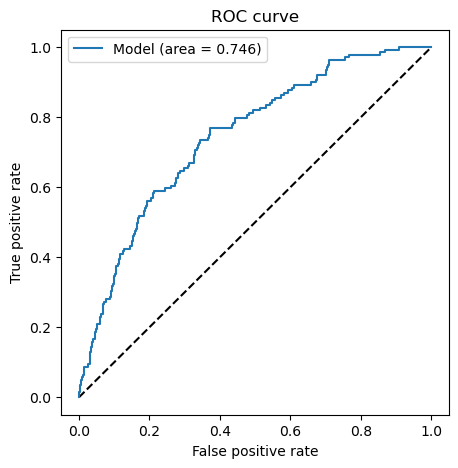

  0%|          | 4/10000 [00:00<05:04, 32.79it/s]

[DeLong] AUC=0.746, AUC COV=0.0, 95% CI=[0.704, 0.787]; AUPRC=0.266, 95% CI=N/A


100%|██████████| 10000/10000 [09:01<00:00, 18.45it/s]

[Bootstrap] AUC=0.746, 95% CI=[0.704, 0.786]; AUPRC=0.266, 95% CI=[0.205, 0.335]


In [12]:
# ECG Features + Embeddings

train(df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64-with-monitoring", consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features + Age + Risk + 12-Lead Embeddings

(10250, 1)
(10250, 64)
        Age    Athero       HTN       HLD        DM     Obese   Smoking  \
0 -0.584271 -0.251278 -0.153851 -0.157624 -0.068592  0.230195  0.018032   
1 -1.058067 -0.592039  1.795012 -0.748582 -0.705868  4.577009 -0.278667   
2 -0.952779 -0.592039 -0.846132 -0.748582 -0.705868 -0.374823 -0.278667   

   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429260  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659139   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720136   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355865 -0.236728 -0.009418  0.093036 -0.156754   -0.281302      0.597273   
1  1.588047  3.630345  3.199030  2.829381  2.889222    0.126420      2.694640   
2 -0.160857  0.736277  0.437660  0.341794  0.346251    0.068174     -0.285829   

   qrsfrontaxis  stfrontaxis  tfro

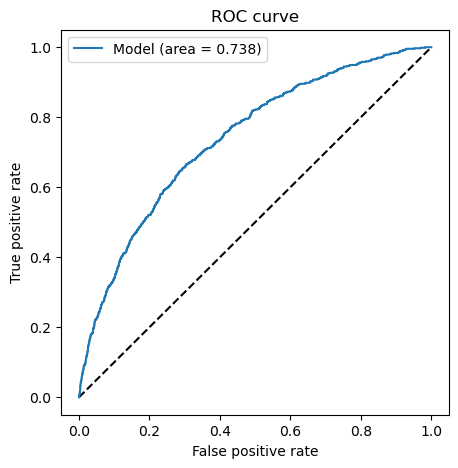

[DeLong] AUC=0.738, AUC COV=0.0, 95% CI=[0.719, 0.758]; AUPRC=0.236, 95% CI=N/A


=== VAL ===


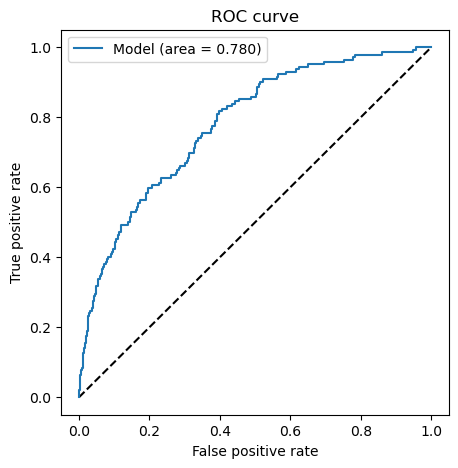

[DeLong] AUC=0.78, AUC COV=0.0, 95% CI=[0.741, 0.82]; AUPRC=0.351, 95% CI=N/A


=== TEST ===


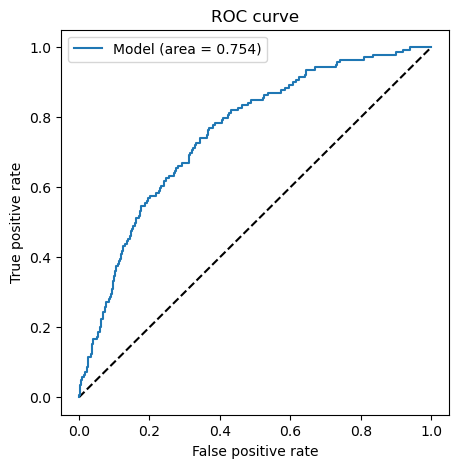

  0%|          | 2/10000 [00:00<11:26, 14.57it/s]

[DeLong] AUC=0.754, AUC COV=0.0, 95% CI=[0.714, 0.795]; AUPRC=0.259, 95% CI=N/A


100%|██████████| 10000/10000 [09:34<00:00, 17.39it/s]

[Bootstrap] AUC=0.754, 95% CI=[0.713, 0.795]; AUPRC=0.259, 95% CI=[0.202, 0.33]


In [13]:
# ECG Features + Embeddings

train(df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64", consolidated_cols=["Age", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"],  
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

### ECG Features + Age + Gender + Vital Signs + Risk + 12-Lead Embeddings + Monitoring Embeddings

(10250, 1)
(10250, 128)
        Age    Gender      SpO2        RR        HR      Temp       SBP  \
0 -0.584271 -0.978968  0.724460 -0.483573 -0.203257  0.092818 -0.250234   
1 -1.058067 -0.978968  0.060218 -0.210237  0.357485 -0.097753 -0.591403   
2 -0.952779  1.020356  0.060218 -1.030243  0.030386  0.283389 -0.173189   

        DBP    Athero       HTN       HLD        DM     Obese   Smoking  \
0 -0.088345 -0.297264 -0.170713 -0.202107 -0.105526  0.298051  0.026961   
1  0.152075 -0.589211  1.785301 -0.745053 -0.698335  4.570488 -0.278311   
2  0.983941 -0.589211 -0.844401 -0.745053 -0.698335 -0.374111 -0.278311   

   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429338  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659217   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720061   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfro

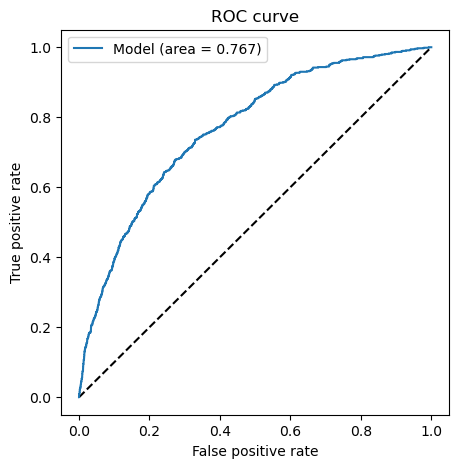

[DeLong] AUC=0.767, AUC COV=0.0, 95% CI=[0.749, 0.785]; AUPRC=0.266, 95% CI=N/A


=== VAL ===


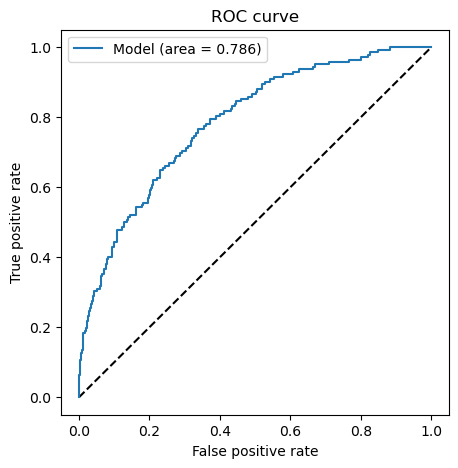

[DeLong] AUC=0.786, AUC COV=0.0, 95% CI=[0.747, 0.825]; AUPRC=0.387, 95% CI=N/A


=== TEST ===


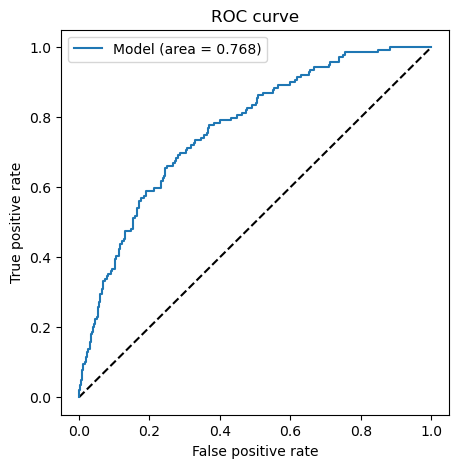

  0%|          | 4/10000 [00:00<05:09, 32.32it/s]

[DeLong] AUC=0.768, AUC COV=0.0, 95% CI=[0.729, 0.808]; AUPRC=0.295, 95% CI=N/A


100%|██████████| 10000/10000 [05:12<00:00, 31.98it/s]

[Bootstrap] AUC=0.768, 95% CI=[0.727, 0.806]; AUPRC=0.295, 95% CI=[0.229, 0.371]


In [36]:
# ECG Features + Embeddings

train(df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-64-with-monitoring", consolidated_cols=["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

## MLP

### Hyperparameter Tuning

In [8]:
best_auroc_val = 0
best_combination = []
for layers in [2, 3, 4]:
    for inner_dim in [32, 64, 128]:
        for dropout in [0, 0.3, 0.5]:
            print(f"RUNNING layers={layers}, inner_dim={inner_dim}, dropout={dropout}")
            mlp = MlpJob(
                df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
                df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
                df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
                summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-only/embeddings_summary.csv",
                embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-only/embeddings.dat.npy",
                save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-only",
                additional_cols=[],
                ordinal_cols=[],
                verbose=0,
                run_bootstrap_ci=False
            )

            auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                                         learning_rate=0.001, 
                                                         dropout_rate=dropout, 
                                                         num_inner_layers=layers, 
                                                         epochs=10, 
                                                         inner_dim=inner_dim)
            print(f"> auroc_train={auroc_train}, auroc_val={auroc_val}, auroc_test={auroc_test}")
            if auroc_val[0] > best_auroc_val:
                best_auroc_val = auroc_val[0]
                best_combination = [layers, inner_dim, dropout]

print("===")
print(f"BEST COMBINATION = {best_combination}")

RUNNING layers=2, inner_dim=32, dropout=0


7246it [00:01, 5496.89it/s]
1283it [00:00, 5698.55it/s]
1278it [00:00, 5705.54it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.706, AUC COV=0.0, 95% CI=[0.685, 0.727]; AUPRC=0.225, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.689, AUC COV=0.001, 95% CI=[0.639, 0.74]; AUPRC=0.264, 95% CI=N/A
[DeLong] AUC=0.706, AUC COV=0.001, 95% CI=[0.659, 0.754]; AUPRC=0.23, 95% CI=N/A
> auroc_train=(0.7057928877510258, 0.22501922303185243), auroc_val=(0.689264420881115, 0.264431091606032), auroc_test=(0.7062613298299026, 0.23005689186239953)
RUNNING layers=2, inner_dim=32, dropout=0.3


7246it [00:01, 5484.76it/s]
1283it [00:00, 5610.87it/s]
1278it [00:00, 5647.78it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.703, AUC COV=0.0, 95% CI=[0.681, 0.724]; AUPRC=0.219, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.69, AUC COV=0.001, 95% CI=[0.64, 0.741]; AUPRC=0.269, 95% CI=N/A
[DeLong] AUC=0.706, AUC COV=0.001, 95% CI=[0.658, 0.754]; AUPRC=0.232, 95% CI=N/A
> auroc_train=(0.7025599647746668, 0.21888863800694325), auroc_val=(0.6904741331424128, 0.26907331739161455), auroc_test=(0.7060844739484969, 0.23233498563490926)
RUNNING layers=2, inner_dim=32, dropout=0.5


7246it [00:01, 5490.85it/s]
1283it [00:00, 5583.06it/s]
1278it [00:00, 5478.25it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.7, AUC COV=0.0, 95% CI=[0.678, 0.721]; AUPRC=0.215, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.691, AUC COV=0.001, 95% CI=[0.641, 0.74]; AUPRC=0.259, 95% CI=N/A
[DeLong] AUC=0.708, AUC COV=0.001, 95% CI=[0.661, 0.756]; AUPRC=0.234, 95% CI=N/A
> auroc_train=(0.6997714438755129, 0.21530485200903104), auroc_val=(0.6905111651504117, 0.25923878109636717), auroc_test=(0.708149897992054, 0.2339402026172741)
RUNNING layers=2, inner_dim=64, dropout=0


7246it [00:01, 5485.16it/s]
1283it [00:00, 5566.09it/s]
1278it [00:00, 5697.87it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.721, AUC COV=0.0, 95% CI=[0.7, 0.741]; AUPRC=0.246, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.702, AUC COV=0.001, 95% CI=[0.651, 0.753]; AUPRC=0.285, 95% CI=N/A
[DeLong] AUC=0.714, AUC COV=0.001, 95% CI=[0.667, 0.761]; AUPRC=0.231, 95% CI=N/A
> auroc_train=(0.720550418527799, 0.24582663817655823), auroc_val=(0.7018553036007456, 0.28473185999474915), auroc_test=(0.7139671932339994, 0.23051181441348972)
RUNNING layers=2, inner_dim=64, dropout=0.3


7246it [00:01, 4789.25it/s]
1283it [00:00, 5657.18it/s]
1278it [00:00, 5649.29it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.713, AUC COV=0.0, 95% CI=[0.692, 0.734]; AUPRC=0.235, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.698, AUC COV=0.001, 95% CI=[0.648, 0.749]; AUPRC=0.28, 95% CI=N/A
[DeLong] AUC=0.71, AUC COV=0.001, 95% CI=[0.662, 0.757]; AUPRC=0.236, 95% CI=N/A
> auroc_train=(0.7127446708065512, 0.23456158136917835), auroc_val=(0.6984421868635124, 0.2798743722727835), auroc_test=(0.7097668660506187, 0.23629407502514094)
RUNNING layers=2, inner_dim=64, dropout=0.5


7246it [00:01, 5458.59it/s]
1283it [00:00, 5377.12it/s]
1278it [00:00, 5482.43it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.708, AUC COV=0.0, 95% CI=[0.687, 0.729]; AUPRC=0.225, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.696, AUC COV=0.001, 95% CI=[0.646, 0.746]; AUPRC=0.281, 95% CI=N/A
[DeLong] AUC=0.707, AUC COV=0.001, 95% CI=[0.66, 0.755]; AUPRC=0.236, 95% CI=N/A
> auroc_train=(0.7075568780186657, 0.22502562214591443), auroc_val=(0.6962696423942428, 0.2813928769930853), auroc_test=(0.7073540465257294, 0.23561777232214542)
RUNNING layers=2, inner_dim=128, dropout=0


7246it [00:01, 4832.74it/s]
1283it [00:00, 5652.14it/s]
1278it [00:00, 5662.05it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.732, AUC COV=0.0, 95% CI=[0.712, 0.753]; AUPRC=0.267, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.703, AUC COV=0.001, 95% CI=[0.653, 0.754]; AUPRC=0.262, 95% CI=N/A
[DeLong] AUC=0.724, AUC COV=0.001, 95% CI=[0.676, 0.771]; AUPRC=0.244, 95% CI=N/A
> auroc_train=(0.7321417547299996, 0.2674212693523171), auroc_val=(0.7032316598980387, 0.2618878129393893), auroc_test=(0.7235805736446839, 0.24382812193105632)
RUNNING layers=2, inner_dim=128, dropout=0.3


7246it [00:01, 5450.29it/s]
1283it [00:00, 5653.27it/s]
1278it [00:00, 5668.15it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.722, AUC COV=0.0, 95% CI=[0.701, 0.743]; AUPRC=0.258, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.701, AUC COV=0.001, 95% CI=[0.65, 0.752]; AUPRC=0.263, 95% CI=N/A
[DeLong] AUC=0.716, AUC COV=0.001, 95% CI=[0.669, 0.763]; AUPRC=0.236, 95% CI=N/A
> auroc_train=(0.7218240458292478, 0.2575569955428144), auroc_val=(0.7009233313994396, 0.26265934541257085), auroc_test=(0.7161842080330467, 0.23625786770736107)
RUNNING layers=2, inner_dim=128, dropout=0.5


7246it [00:01, 5485.90it/s]
1283it [00:00, 5653.43it/s]
1278it [00:00, 5543.52it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.714, AUC COV=0.0, 95% CI=[0.693, 0.735]; AUPRC=0.246, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.698, AUC COV=0.001, 95% CI=[0.648, 0.749]; AUPRC=0.266, 95% CI=N/A
[DeLong] AUC=0.713, AUC COV=0.001, 95% CI=[0.665, 0.76]; AUPRC=0.233, 95% CI=N/A
> auroc_train=(0.7144013055162146, 0.24553924997722065), auroc_val=(0.6984113268568465, 0.2658605348606662), auroc_test=(0.712533397338319, 0.23326639682606767)
RUNNING layers=3, inner_dim=32, dropout=0


7246it [00:01, 5497.03it/s]
1283it [00:00, 5650.61it/s]
1278it [00:00, 5653.55it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.72, AUC COV=0.0, 95% CI=[0.699, 0.74]; AUPRC=0.222, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.703, AUC COV=0.001, 95% CI=[0.652, 0.753]; AUPRC=0.275, 95% CI=N/A
[DeLong] AUC=0.723, AUC COV=0.001, 95% CI=[0.677, 0.77]; AUPRC=0.245, 95% CI=N/A
> auroc_train=(0.7198439826415368, 0.22246280811792815), auroc_val=(0.7025095357420597, 0.2747017686321325), auroc_test=(0.7233974014817997, 0.244821971521201)
RUNNING layers=3, inner_dim=32, dropout=0.3


7246it [00:01, 5482.72it/s]
1283it [00:00, 5699.26it/s]
1278it [00:00, 5677.22it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.71, AUC COV=0.0, 95% CI=[0.69, 0.731]; AUPRC=0.219, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.697, AUC COV=0.001, 95% CI=[0.647, 0.747]; AUPRC=0.268, 95% CI=N/A
[DeLong] AUC=0.719, AUC COV=0.001, 95% CI=[0.672, 0.765]; AUPRC=0.235, 95% CI=N/A
> auroc_train=(0.7102871817917711, 0.21887446150711892), auroc_val=(0.6970041105528879, 0.2682437837776908), auroc_test=(0.7188117811282143, 0.2352220973253442)
RUNNING layers=3, inner_dim=32, dropout=0.5


7246it [00:01, 5457.62it/s]
1283it [00:00, 5544.66it/s]
1278it [00:00, 5650.91it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.706, AUC COV=0.0, 95% CI=[0.685, 0.727]; AUPRC=0.22, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.696, AUC COV=0.001, 95% CI=[0.646, 0.746]; AUPRC=0.264, 95% CI=N/A
[DeLong] AUC=0.717, AUC COV=0.001, 95% CI=[0.67, 0.763]; AUPRC=0.232, 95% CI=N/A
> auroc_train=(0.7063144587282566, 0.2199411417643198), auroc_val=(0.6961832343755786, 0.26448754007742814), auroc_test=(0.7166137151736028, 0.2316875468881847)
RUNNING layers=3, inner_dim=64, dropout=0


7246it [00:01, 5496.74it/s]
1283it [00:00, 5669.29it/s]
1278it [00:00, 5391.62it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.752, AUC COV=0.0, 95% CI=[0.732, 0.771]; AUPRC=0.281, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.717, AUC COV=0.001, 95% CI=[0.669, 0.766]; AUPRC=0.26, 95% CI=N/A
[DeLong] AUC=0.741, AUC COV=0.0, 95% CI=[0.698, 0.784]; AUPRC=0.25, 95% CI=N/A
> auroc_train=(0.7517562733776374, 0.2807281342488296), auroc_val=(0.717433434965622, 0.2597984092928698), auroc_test=(0.7408240220817199, 0.249689508169883)
RUNNING layers=3, inner_dim=64, dropout=0.3


7246it [00:01, 5453.97it/s]
1283it [00:00, 5643.66it/s]
1278it [00:00, 5716.46it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.725, AUC COV=0.0, 95% CI=[0.705, 0.746]; AUPRC=0.242, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.706, AUC COV=0.001, 95% CI=[0.657, 0.756]; AUPRC=0.279, 95% CI=N/A
[DeLong] AUC=0.725, AUC COV=0.001, 95% CI=[0.679, 0.77]; AUPRC=0.247, 95% CI=N/A
> auroc_train=(0.7252644169662636, 0.2419645572489958), auroc_val=(0.7063855525792793, 0.2787303550791104), auroc_test=(0.7246732903405108, 0.246707230029362)
RUNNING layers=3, inner_dim=64, dropout=0.5


7246it [00:01, 5408.64it/s]
1283it [00:00, 5585.95it/s]
1278it [00:00, 5643.30it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.715, AUC COV=0.0, 95% CI=[0.694, 0.736]; AUPRC=0.229, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.7, AUC COV=0.001, 95% CI=[0.649, 0.75]; AUPRC=0.285, 95% CI=N/A
[DeLong] AUC=0.719, AUC COV=0.001, 95% CI=[0.673, 0.765]; AUPRC=0.236, 95% CI=N/A
> auroc_train=(0.7149278697752116, 0.22861354365430206), auroc_val=(0.6998494031674711, 0.2848614555176736), auroc_test=(0.7188686276615232, 0.23634190547255887)
RUNNING layers=3, inner_dim=128, dropout=0


7246it [00:01, 5493.47it/s]
1283it [00:00, 5484.15it/s]
1278it [00:00, 5681.66it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.789, AUC COV=0.0, 95% CI=[0.771, 0.808]; AUPRC=0.359, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.733, AUC COV=0.001, 95% CI=[0.688, 0.779]; AUPRC=0.266, 95% CI=N/A
[DeLong] AUC=0.745, AUC COV=0.0, 95% CI=[0.702, 0.788]; AUPRC=0.255, 95% CI=N/A
> auroc_train=(0.7891743381631986, 0.3586846054946194), auroc_val=(0.7333325103998222, 0.26560240458593887), auroc_test=(0.7447906468503863, 0.2545762317968979)
RUNNING layers=3, inner_dim=128, dropout=0.3


7246it [00:01, 5440.51it/s]
1283it [00:00, 5701.74it/s]
1278it [00:00, 5670.84it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.762, AUC COV=0.0, 95% CI=[0.743, 0.781]; AUPRC=0.3, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.724, AUC COV=0.001, 95% CI=[0.677, 0.771]; AUPRC=0.267, 95% CI=N/A
[DeLong] AUC=0.753, AUC COV=0.0, 95% CI=[0.711, 0.795]; AUPRC=0.257, 95% CI=N/A
> auroc_train=(0.7618501924683153, 0.2998871581927244), auroc_val=(0.7238893483600992, 0.2672520011930087), auroc_test=(0.7532039337801049, 0.257234944798361)
RUNNING layers=3, inner_dim=128, dropout=0.5


7246it [00:01, 5491.09it/s]
1283it [00:00, 5572.40it/s]
1278it [00:00, 5640.43it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.741, AUC COV=0.0, 95% CI=[0.721, 0.761]; AUPRC=0.266, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.717, AUC COV=0.001, 95% CI=[0.669, 0.765]; AUPRC=0.274, 95% CI=N/A
[DeLong] AUC=0.741, AUC COV=0.0, 95% CI=[0.697, 0.785]; AUPRC=0.241, 95% CI=N/A
> auroc_train=(0.7408437965283075, 0.26555329296465185), auroc_val=(0.7169396748589697, 0.2738323413652191), auroc_test=(0.7409566639927743, 0.2410264194013647)
RUNNING layers=4, inner_dim=32, dropout=0


7246it [00:01, 5458.50it/s]
1283it [00:00, 5585.45it/s]
1278it [00:00, 5655.21it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.751, AUC COV=0.0, 95% CI=[0.732, 0.77]; AUPRC=0.271, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.724, AUC COV=0.001, 95% CI=[0.677, 0.771]; AUPRC=0.262, 95% CI=N/A
[DeLong] AUC=0.739, AUC COV=0.001, 95% CI=[0.695, 0.782]; AUPRC=0.247, 95% CI=N/A
> auroc_train=(0.751068108363293, 0.27094203026024716), auroc_val=(0.7244139684734172, 0.26221530115467706), auroc_test=(0.7385059467790123, 0.24724157738885308)
RUNNING layers=4, inner_dim=32, dropout=0.3


7246it [00:01, 5443.94it/s]
1283it [00:00, 5660.02it/s]
1278it [00:00, 5655.43it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.731, AUC COV=0.0, 95% CI=[0.711, 0.751]; AUPRC=0.234, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.713, AUC COV=0.001, 95% CI=[0.665, 0.762]; AUPRC=0.275, 95% CI=N/A
[DeLong] AUC=0.731, AUC COV=0.001, 95% CI=[0.686, 0.776]; AUPRC=0.247, 95% CI=N/A
> auroc_train=(0.7306197116606747, 0.23403512815066166), auroc_val=(0.7132364740590784, 0.2746663385188867), auroc_test=(0.730566380960201, 0.24724118130147127)
RUNNING layers=4, inner_dim=32, dropout=0.5


7246it [00:01, 5488.57it/s]
1283it [00:00, 5694.09it/s]
1278it [00:00, 5686.59it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.719, AUC COV=0.0, 95% CI=[0.698, 0.739]; AUPRC=0.218, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.708, AUC COV=0.001, 95% CI=[0.659, 0.757]; AUPRC=0.261, 95% CI=N/A
[DeLong] AUC=0.724, AUC COV=0.001, 95% CI=[0.679, 0.77]; AUPRC=0.227, 95% CI=N/A
> auroc_train=(0.7189256727312343, 0.21782845498897), auroc_val=(0.7082494969818913, 0.26142286834615), auroc_test=(0.7244964344591053, 0.2269056009974077)
RUNNING layers=4, inner_dim=64, dropout=0


7246it [00:01, 5451.91it/s]
1283it [00:00, 5667.51it/s]
1278it [00:00, 5655.28it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.769, AUC COV=0.0, 95% CI=[0.75, 0.789]; AUPRC=0.32, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.717, AUC COV=0.001, 95% CI=[0.669, 0.764]; AUPRC=0.254, 95% CI=N/A
[DeLong] AUC=0.751, AUC COV=0.0, 95% CI=[0.709, 0.794]; AUPRC=0.271, 95% CI=N/A
> auroc_train=(0.769440775138904, 0.3200623052354174), auroc_val=(0.716908814852304, 0.25387771578829477), auroc_test=(0.7514164261216136, 0.27106448313752957)
RUNNING layers=4, inner_dim=64, dropout=0.3


7246it [00:01, 5454.45it/s]
1283it [00:00, 5617.74it/s]
1278it [00:00, 5596.80it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.739, AUC COV=0.0, 95% CI=[0.719, 0.759]; AUPRC=0.249, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.712, AUC COV=0.001, 95% CI=[0.663, 0.76]; AUPRC=0.285, 95% CI=N/A
[DeLong] AUC=0.745, AUC COV=0.0, 95% CI=[0.702, 0.789]; AUPRC=0.267, 95% CI=N/A
> auroc_train=(0.7387696553727712, 0.24937726746485006), auroc_val=(0.7117305057337892, 0.28532481682595684), auroc_test=(0.7452327865539, 0.26677932360544526)
RUNNING layers=4, inner_dim=64, dropout=0.5


7246it [00:01, 5377.40it/s]
1283it [00:00, 5689.17it/s]
1278it [00:00, 5424.85it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.724, AUC COV=0.0, 95% CI=[0.703, 0.744]; AUPRC=0.228, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.708, AUC COV=0.001, 95% CI=[0.659, 0.758]; AUPRC=0.291, 95% CI=N/A
[DeLong] AUC=0.733, AUC COV=0.001, 95% CI=[0.688, 0.778]; AUPRC=0.251, 95% CI=N/A
> auroc_train=(0.7237928741329847, 0.22805342448289312), auroc_val=(0.7084223130192197, 0.2905925909127663), auroc_test=(0.7328655074184726, 0.2511986541314006)
RUNNING layers=4, inner_dim=128, dropout=0


7246it [00:01, 5411.25it/s]
1283it [00:00, 5632.39it/s]
1278it [00:00, 5617.51it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.827, AUC COV=0.0, 95% CI=[0.81, 0.845]; AUPRC=0.476, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.725, AUC COV=0.001, 95% CI=[0.678, 0.771]; AUPRC=0.26, 95% CI=N/A
[DeLong] AUC=0.731, AUC COV=0.001, 95% CI=[0.687, 0.775]; AUPRC=0.241, 95% CI=N/A
> auroc_train=(0.8273420761157715, 0.47558396433468586), auroc_val=(0.7247657725494069, 0.26018227429089347), auroc_test=(0.7311222137303327, 0.2412562264748287)
RUNNING layers=4, inner_dim=128, dropout=0.3


7246it [00:01, 5500.41it/s]
1283it [00:00, 5548.50it/s]
1278it [00:00, 5645.63it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.775, AUC COV=0.0, 95% CI=[0.757, 0.794]; AUPRC=0.315, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.738, AUC COV=0.001, 95% CI=[0.693, 0.783]; AUPRC=0.274, 95% CI=N/A
[DeLong] AUC=0.745, AUC COV=0.0, 95% CI=[0.702, 0.787]; AUPRC=0.252, 95% CI=N/A
> auroc_train=(0.7752943766568617, 0.3146298970836447), auroc_val=(0.7381960474503462, 0.27355861431749373), auroc_test=(0.7446453723763746, 0.2515509162342863)
RUNNING layers=4, inner_dim=128, dropout=0.5


7246it [00:01, 5468.57it/s]
1283it [00:00, 5558.24it/s]
1278it [00:00, 5562.61it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 1234
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be r

[DeLong] AUC=0.754, AUC COV=0.0, 95% CI=[0.735, 0.773]; AUPRC=0.27, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.726, AUC COV=0.001, 95% CI=[0.679, 0.772]; AUPRC=0.27, 95% CI=N/A
[DeLong] AUC=0.742, AUC COV=0.0, 95% CI=[0.699, 0.785]; AUPRC=0.247, 95% CI=N/A
> auroc_train=(0.7538657079565676, 0.2695154078730403), auroc_val=(0.7255619607213835, 0.27019217794092004), auroc_test=(0.7422830831033154, 0.24666022319463152)
===
BEST COMBINATION = [4, 128, 0.3]


### ECG Features Only

In [21]:
# ECG 
save("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-only", df_train, df_val, df_test, processed, consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])


   meanqrsdur  meanprint  heartrate     rrint      pdur    qonset    tonset  \
0   -0.243412  -0.429454  -0.661087  0.505166  0.148292  0.870071  0.323070   
1    2.241885  -0.659404   0.585613 -0.754479  0.650392 -0.560502  1.293467   
2   -0.243412   0.720297   0.539439 -0.690430  0.148292  0.727014 -0.899630   

      qtint      qtcb      qtcf     QTcFM      QTcH  pfrontaxis  i40frontaxis  \
0  0.355860 -0.236728 -0.009418  0.093036 -0.156754   -0.281770      0.597293   
1  1.586831  3.630345  3.199030  2.829381  2.889222    0.126090      2.694667   
2 -0.160353  0.736277  0.437660  0.341794  0.346251    0.067824     -0.285812   

   qrsfrontaxis  stfrontaxis  tfrontaxis  phorizaxis  i40horizaxis  \
0     -0.555135    -0.079516   -0.113176    0.260027      0.345515   
1      0.825396    -1.412913    4.272147   -0.231760      0.467736   
2     -0.555135    -0.852139   -0.700497   -0.157992     -0.461148   

   t40horizaxis  qrshorizaxis  sthorizaxis  
0      1.748398     -0.142217   

Read df_train with shape = (7246, 79), pos = (670, 79), neg = (6576, 79)
Read df_val with shape = (1283, 79), pos = (142, 79), neg = (1141, 79)
Read df_test with shape = (1278, 79), pos = (139, 79), neg = (1139, 79)


7246it [00:01, 5442.98it/s]


Produced embedding for df_train_x with shape = (7246, 24)


1283it [00:00, 5513.17it/s]


Produced embedding for df_val_x with shape = (1283, 24)


1278it [00:00, 5409.49it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Produced embedding for df_test_x with shape = (1278, 24)
Starting model training...



  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | model | MLP               | 36.1 K
--------------------------------------------
36.1 K    Trainable params
0         Non-trainable params
36.1 K    Total params
0.144     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1234


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------------------------------------


============= TRAIN ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

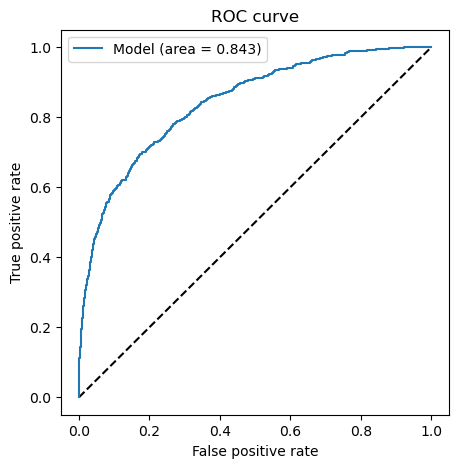

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.843, AUC COV=0.0, 95% CI=[0.827, 0.859]; AUPRC=0.481, 95% CI=N/A
TRAIN AUROC = (0.8431206195300868, 0.4810283979664761) AUPRC = 0.4810283979664761 using data size 7246 with 670 ACS
Best Checkpoint = 


============= VAL ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

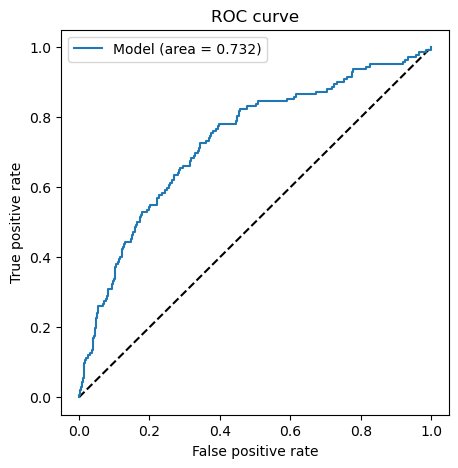

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.732, AUC COV=0.001, 95% CI=[0.686, 0.778]; AUPRC=0.256, 95% CI=N/A
VAL AUROC = (0.7317277900532025, 0.25648810321553894) AUPRC = 0.25648810321553894 using data size 1283 with 142 pos


============= TEST ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

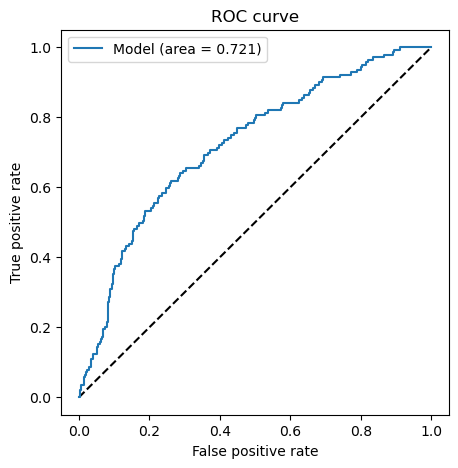

  0%|          | 4/10000 [00:00<05:14, 31.74it/s]

[DeLong] AUC=0.721, AUC COV=0.001, 95% CI=[0.676, 0.766]; AUPRC=0.227, 95% CI=N/A


100%|██████████| 10000/10000 [05:16<00:00, 31.61it/s]


[Bootstrap] AUC=0.721, 95% CI=[0.675, 0.764]; AUPRC=0.227, 95% CI=[0.178, 0.288]
TEST AUROC = (0.7211172238679644, 0.22676401499821575) AUPRC = 0.22676401499821575 using data size 1278 with 139 pos


============= TRAIN/VAL LOSS CURVE ===============


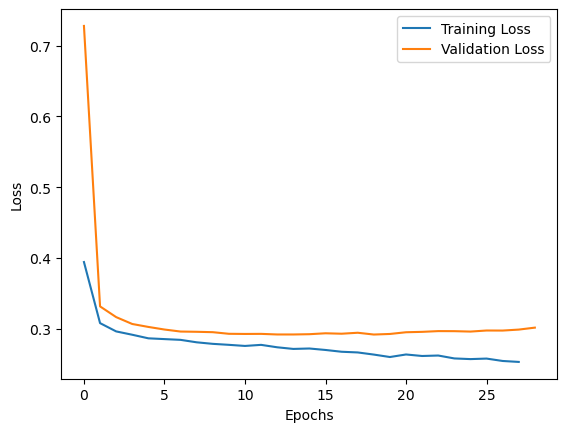

In [9]:
mlp = MlpJob(
    df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
    df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
    df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
    summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-only/embeddings_summary.csv",
    embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-only/embeddings.dat.npy",
    save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-only",
    additional_cols=[],
    ordinal_cols=[],
    verbose=1,
    run_bootstrap_ci=True
)

auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                             learning_rate=0.001, 
                                             dropout_rate=0.3, 
                                             num_inner_layers=4, 
                                             epochs=100, 
                                             inner_dim=128,
                                             patience=10)

### ECG Features + Age + Sex + Vital Signs + Risk

In [31]:
save("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo", df_train, df_val, df_test, processed, normalize=True, consolidated_cols=["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

Read df_train with shape = (7246, 79), pos = (670, 79), neg = (6576, 79)
Read df_val with shape = (1283, 79), pos = (142, 79), neg = (1141, 79)
Read df_test with shape = (1278, 79), pos = (139, 79), neg = (1139, 79)


7246it [00:01, 5395.71it/s]


Produced embedding for df_train_x with shape = (7246, 38)


1283it [00:00, 5485.39it/s]


Produced embedding for df_val_x with shape = (1283, 38)


1278it [00:00, 5514.63it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | model | MLP               | 37.9 K
--------------------------------------------
37.9 K    Trainable params
0         Non-trainable params
37.9 K    Total params
0.152     Total estimated model params size (MB)


Produced embedding for df_test_x with shape = (1278, 38)
Starting model training...


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1234


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------------------------------------


============= TRAIN ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

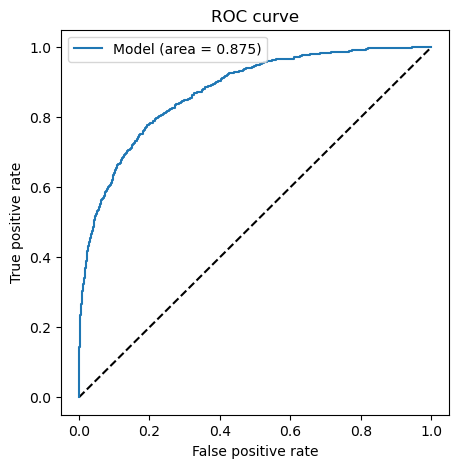

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.875, AUC COV=0.0, 95% CI=[0.861, 0.888]; AUPRC=0.553, 95% CI=N/A
TRAIN AUROC = (0.8745399371754367, 0.5529749644141535) AUPRC = 0.5529749644141535 using data size 7246 with 670 ACS
Best Checkpoint = 


============= VAL ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

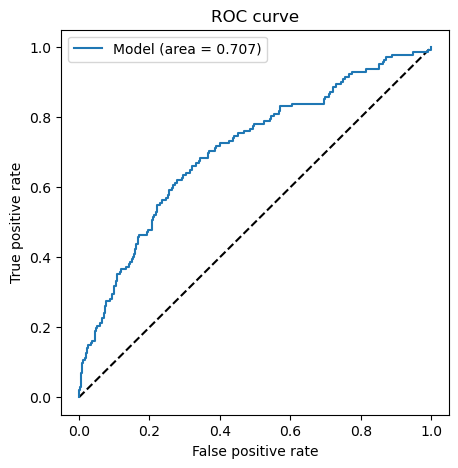

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.707, AUC COV=0.001, 95% CI=[0.66, 0.754]; AUPRC=0.269, 95% CI=N/A
VAL AUROC = (0.7069286886965968, 0.26854913387231205) AUPRC = 0.26854913387231205 using data size 1283 with 142 pos


============= TEST ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

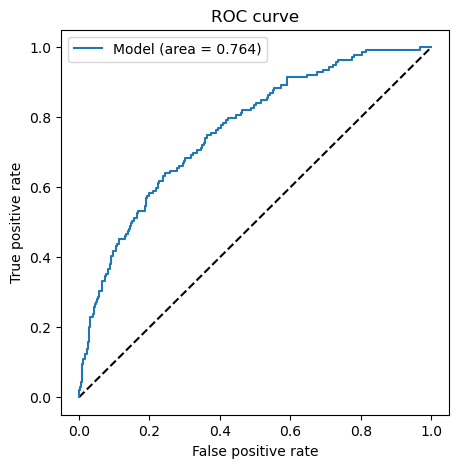

  0%|          | 4/10000 [00:00<05:16, 31.59it/s]

[DeLong] AUC=0.764, AUC COV=0.0, 95% CI=[0.723, 0.805]; AUPRC=0.307, 95% CI=N/A


100%|██████████| 10000/10000 [05:19<00:00, 31.33it/s]


[Bootstrap] AUC=0.764, 95% CI=[0.721, 0.804]; AUPRC=0.307, 95% CI=[0.238, 0.387]
TEST AUROC = (0.7642005798346398, 0.3068643868377181) AUPRC = 0.3068643868377181 using data size 1278 with 139 pos


============= TRAIN/VAL LOSS CURVE ===============


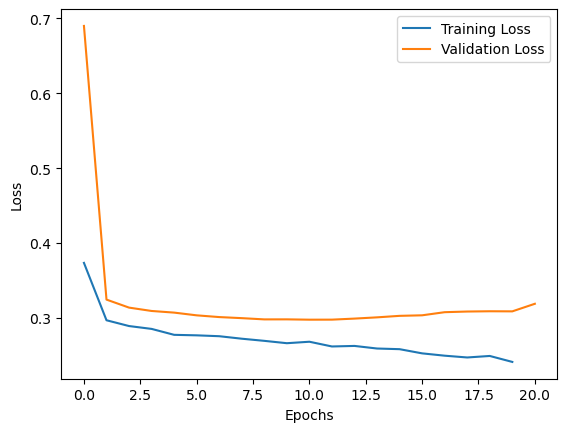

In [10]:
mlp = MlpJob(
    df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
    df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
    df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
    summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo/embeddings_summary.csv",
    embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo/embeddings.dat.npy",
    save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-demo",
    additional_cols=[],
    ordinal_cols=[],
    verbose=1,
    run_bootstrap_ci=True
)

auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                             learning_rate=0.001, 
                                             dropout_rate=0.3, 
                                             num_inner_layers=4, 
                                             epochs=100, 
                                             inner_dim=128,
                                             patience=10)

### ECG Features + 12-Lead Embeddings

In [ ]:
# ECG Features + Embeddings

save("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed", df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-256", consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

In [ ]:
summary_df = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed/embeddings_summary.csv")
summary_df.head(2)

In [11]:
arr = np.load("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed/embeddings.dat.npy")
arr.shape

(9807, 278)

Read df_train with shape = (7246, 79), pos = (670, 79), neg = (6576, 79)
Read df_val with shape = (1283, 79), pos = (142, 79), neg = (1141, 79)
Read df_test with shape = (1278, 79), pos = (139, 79), neg = (1139, 79)


7246it [00:01, 4006.60it/s]


Produced embedding for df_train_x with shape = (7246, 280)


1283it [00:00, 4641.29it/s]


Produced embedding for df_val_x with shape = (1283, 280)


1278it [00:00, 4549.80it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | model | MLP               | 68.9 K
--------------------------------------------
68.9 K    Trainable params
0         Non-trainable params
68.9 K    Total params
0.275     Total estimated model params size (MB)


Produced embedding for df_test_x with shape = (1278, 280)
Starting model training...


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1234


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------------------------------------


============= TRAIN ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

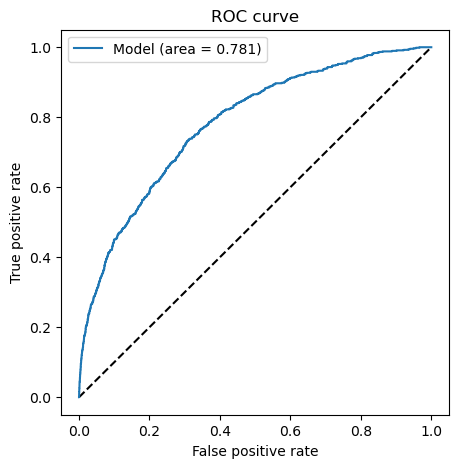

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.781, AUC COV=0.0, 95% CI=[0.763, 0.8]; AUPRC=0.327, 95% CI=N/A
TRAIN AUROC = (0.7814492773359478, 0.327164586914915) AUPRC = 0.327164586914915 using data size 7246 with 670 ACS
Best Checkpoint = 


============= VAL ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

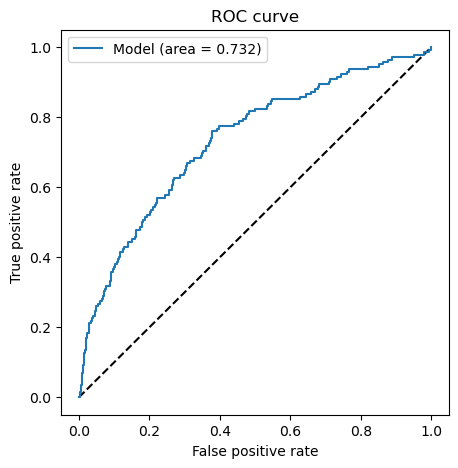

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.732, AUC COV=0.001, 95% CI=[0.687, 0.778]; AUPRC=0.279, 95% CI=N/A
VAL AUROC = (0.7323635061905174, 0.27890536777288) AUPRC = 0.27890536777288 using data size 1283 with 142 pos


============= TEST ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

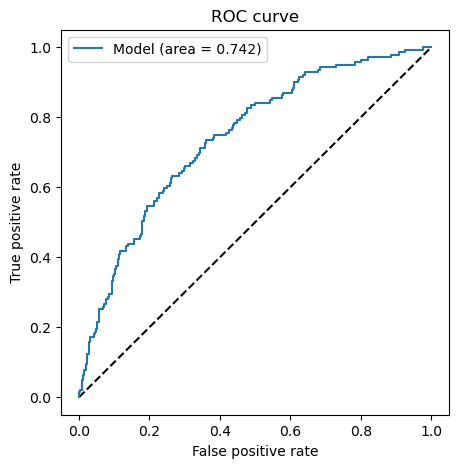

  0%|          | 4/10000 [00:00<05:15, 31.67it/s]

[DeLong] AUC=0.742, AUC COV=0.0, 95% CI=[0.7, 0.784]; AUPRC=0.26, 95% CI=N/A


100%|██████████| 10000/10000 [05:17<00:00, 31.53it/s]


[Bootstrap] AUC=0.742, 95% CI=[0.7, 0.784]; AUPRC=0.26, 95% CI=[0.2, 0.331]
TEST AUROC = (0.7420746458145161, 0.2600726116751979) AUPRC = 0.2600726116751979 using data size 1278 with 139 pos


============= TRAIN/VAL LOSS CURVE ===============


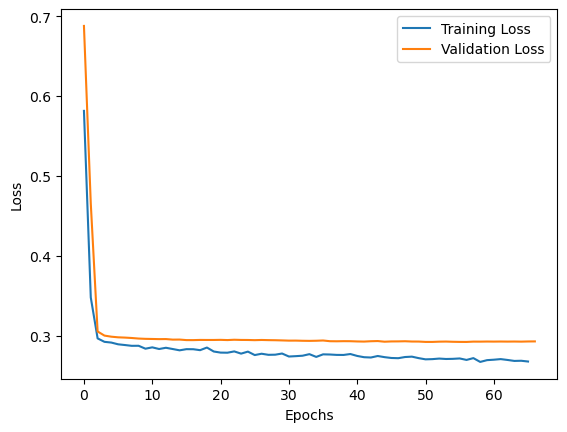

In [11]:
mlp = MlpJob(
    df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
    df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
    df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
    summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed/embeddings_summary.csv",
    embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed/embeddings.dat.npy",
    save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-12leadembed",
    additional_cols=[],
    ordinal_cols=[],
    verbose=1,
    run_bootstrap_ci=True
)

auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                             learning_rate=0.0001, 
                                             dropout_rate=0.3, 
                                             num_inner_layers=4, 
                                             epochs=100, 
                                             inner_dim=128,
                                             patience=10)

### ECG Features + 12-Lead Embeddings + Monitoring Embeddings

In [12]:
# ECG Features + Embeddings
save("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed-monitor", df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-256-with-monitoring", consolidated_cols=[], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

(10250, 1)
(10250, 320)


Read df_train with shape = (7246, 79), pos = (670, 79), neg = (6576, 79)
Read df_val with shape = (1283, 79), pos = (142, 79), neg = (1141, 79)
Read df_test with shape = (1278, 79), pos = (139, 79), neg = (1139, 79)


7246it [00:01, 4393.72it/s]


Produced embedding for df_train_x with shape = (7246, 344)


1283it [00:00, 4464.02it/s]


Produced embedding for df_val_x with shape = (1283, 344)


1278it [00:00, 4532.28it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | model | MLP               | 77.1 K
--------------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.308     Total estimated model params size (MB)


Produced embedding for df_test_x with shape = (1278, 344)
Starting model training...


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1234


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------------------------------------


============= TRAIN ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

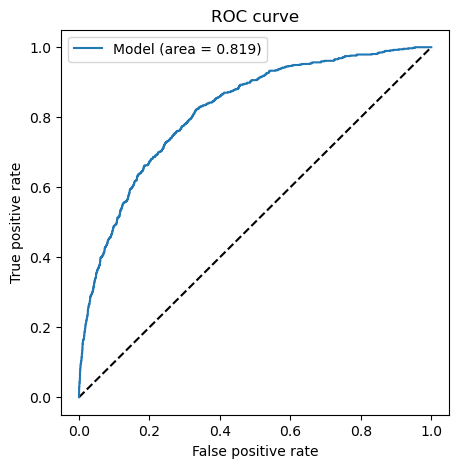

[DeLong] AUC=0.819, AUC COV=0.0, 95% CI=[0.803, 0.835]; AUPRC=0.372, 95% CI=N/A


/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TRAIN AUROC = (0.8190307586156806, 0.3716994431170888) AUPRC = 0.3716994431170888 using data size 7246 with 670 ACS
Best Checkpoint = 


============= VAL ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

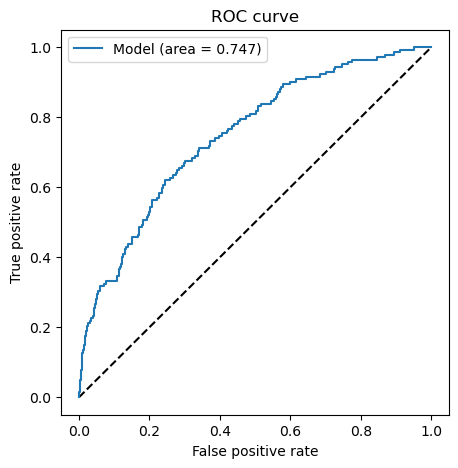

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.747, AUC COV=0.0, 95% CI=[0.705, 0.789]; AUPRC=0.315, 95% CI=N/A
VAL AUROC = (0.7470158373554209, 0.31473437723450914) AUPRC = 0.31473437723450914 using data size 1283 with 142 pos


============= TEST ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

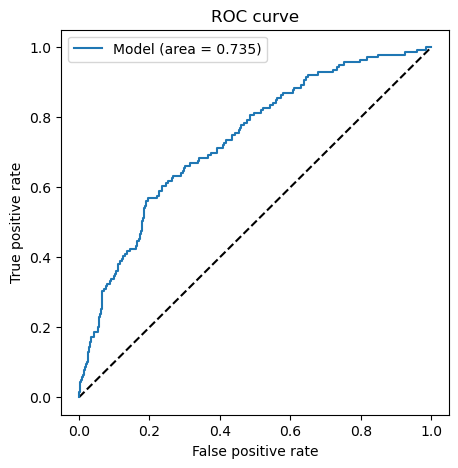

  0%|          | 4/10000 [00:00<05:17, 31.53it/s]

[DeLong] AUC=0.735, AUC COV=0.0, 95% CI=[0.691, 0.778]; AUPRC=0.27, 95% CI=N/A


100%|██████████| 10000/10000 [05:19<00:00, 31.35it/s]


[Bootstrap] AUC=0.735, 95% CI=[0.69, 0.777]; AUPRC=0.27, 95% CI=[0.207, 0.343]
TEST AUROC = (0.734785656988018, 0.27020669576852435) AUPRC = 0.27020669576852435 using data size 1278 with 139 pos


============= TRAIN/VAL LOSS CURVE ===============


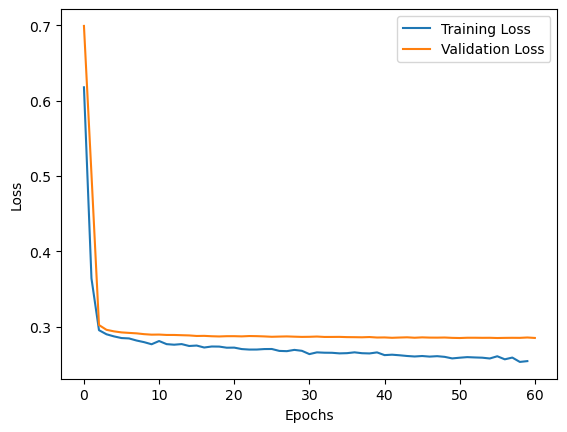

In [13]:
mlp = MlpJob(
    df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
    df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
    df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
    summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed-monitor/embeddings_summary.csv",
    embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-12leadembed-monitor/embeddings.dat.npy",
    save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-12leadembed-monitor",
    additional_cols=[],
    ordinal_cols=[],
    verbose=1,
    run_bootstrap_ci=True
)

auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                             learning_rate=0.0001, 
                                             dropout_rate=0.3, 
                                             num_inner_layers=4, 
                                             epochs=100, 
                                             inner_dim=128,
                                             patience=10)

### ECG Features + Age + Gender + Vital Signs + Risk + 12-Lead Embeddings + Monitoring Embeddings

In [14]:
# ECG Features + Embeddings

save("/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo-12leadembed-monitor", df_train, df_val, df_test, processed, embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead/transformer-256-with-monitoring", consolidated_cols=["Age", "Gender", "SpO2", "RR", "HR", "Temp", "SBP", "DBP", "Athero", "HTN", "HLD", "DM", "Obese", "Smoking"], 
      processed_cols=["meanqrsdur", "meanprint", "heartrate", "rrint", "pdur", "qonset", "tonset", "qtint", "qtcb", "qtcf", "QTcFM", "QTcH", "pfrontaxis", "i40frontaxis", "qrsfrontaxis", "stfrontaxis", "tfrontaxis", "phorizaxis", "i40horizaxis", "t40horizaxis", "qrshorizaxis", "sthorizaxis"])

(10250, 1)
(10250, 320)


Read df_train with shape = (7246, 79), pos = (670, 79), neg = (6576, 79)
Read df_val with shape = (1283, 79), pos = (142, 79), neg = (1141, 79)
Read df_test with shape = (1278, 79), pos = (139, 79), neg = (1139, 79)


7246it [00:01, 4374.74it/s]


Produced embedding for df_train_x with shape = (7246, 358)


1283it [00:00, 4478.82it/s]


Produced embedding for df_val_x with shape = (1283, 358)


1278it [00:00, 4493.88it/s]
Global seed set to 1234
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | loss  | BCEWithLogitsLoss | 0     
1 | model | MLP               | 78.8 K
--------------------------------------------
78.8 K    Trainable params
0         Non-trainable params
78.8 K    Total params
0.315     Total estimated model params size (MB)


Produced embedding for df_test_x with shape = (1278, 358)
Starting model training...


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1234


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------------------------------------


============= TRAIN ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

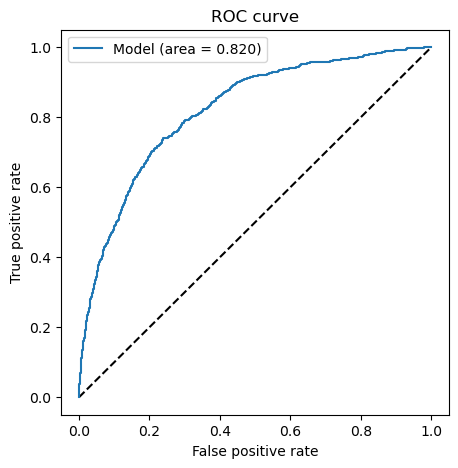

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.82, AUC COV=0.0, 95% CI=[0.803, 0.836]; AUPRC=0.364, 95% CI=N/A
TRAIN AUROC = (0.819946344917747, 0.3638956217282752) AUPRC = 0.3638956217282752 using data size 7246 with 670 ACS
Best Checkpoint = 


============= VAL ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

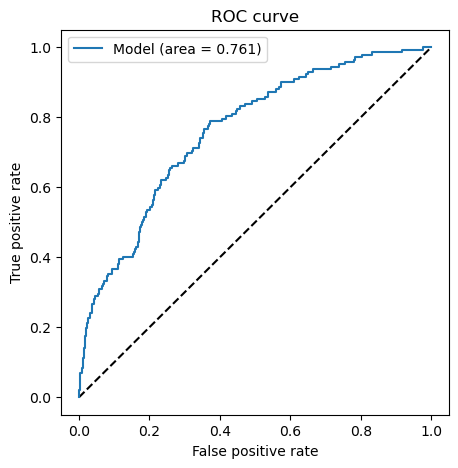

/deep/u/tomjin/miniconda3/envs/ml/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[DeLong] AUC=0.761, AUC COV=0.0, 95% CI=[0.72, 0.801]; AUPRC=0.333, 95% CI=N/A
VAL AUROC = (0.7607547123230178, 0.33287802212693285) AUPRC = 0.33287802212693285 using data size 1283 with 142 pos


============= TEST ROC CURVE ===============


Testing: 0it [00:00, ?it/s]

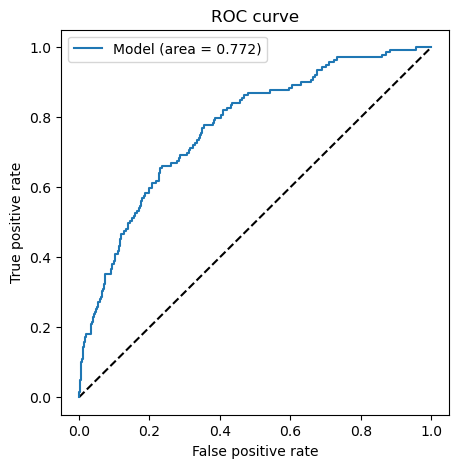

  0%|          | 4/10000 [00:00<05:16, 31.59it/s]

[DeLong] AUC=0.772, AUC COV=0.0, 95% CI=[0.732, 0.813]; AUPRC=0.321, 95% CI=N/A


100%|██████████| 10000/10000 [05:17<00:00, 31.48it/s]


[Bootstrap] AUC=0.772, 95% CI=[0.731, 0.812]; AUPRC=0.321, 95% CI=[0.249, 0.408]
TEST AUROC = (0.7723170015348563, 0.32065261375766935) AUPRC = 0.32065261375766935 using data size 1278 with 139 pos


============= TRAIN/VAL LOSS CURVE ===============


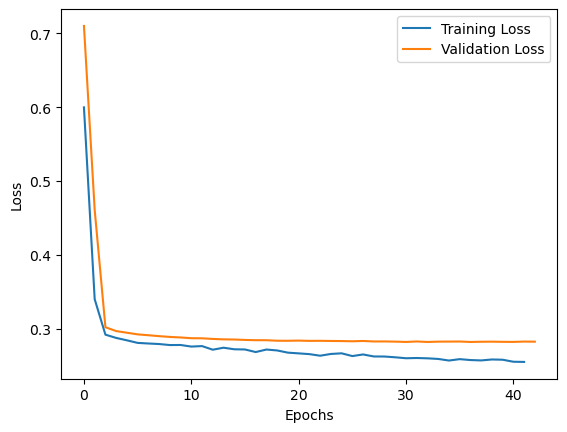

In [15]:
mlp = MlpJob(
    df_train_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.train.txt",
    df_val_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.val.txt",
    df_test_path="/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.12lead.test.txt",
    summary_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo-12leadembed-monitor/embeddings_summary.csv",
    embeddings_path="/deep/group/ed-monitor/patient_data_v9/waveforms/12-lead-features/features-demo-12leadembed-monitor/embeddings.dat.npy",
    save_predictions_path="/deep/group/ed-monitor/patient_data_v9/predictions/12-lead-features/features-demo-12leadembed-monitor",
    additional_cols=[],
    ordinal_cols=[],
    verbose=1,
    run_bootstrap_ci=True
)

auroc_train, auroc_val, auroc_test = mlp.run(batch_size=128, 
                                             learning_rate=0.0001, 
                                             dropout_rate=0.3, 
                                             num_inner_layers=4, 
                                             epochs=100, 
                                             inner_dim=128,
                                             patience=10)